# Lab 3: Time Series Analysis - Disecting Time Characteristics in a Google Search Term and ARIMA modeling

by Group 8: Tony Chan, Lu Han, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara

We will be making an app which will analysis the time characteristics of a google search term. We will be using Google Trends API to obtain "interest over time()" for a keyword of interest, and we will extract time series characteristics of this term and determine whether this search has upword/downword trend, and seasonality of this keyword. Finally, we will give forecast on the trend in the future.

Idea for this lab was originated from [Time Series Analysis Tutorial with Python
on DataCamp](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial)

You can get google trend data from [here](https://trends.google.com/trends/explore?date=all&q=bike,jetski,snowboard) with keywords = [bike, jetski, snowboard]

In [25]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import seaborn as sns

from pytrends.request import TrendReq

%matplotlib inline

In [26]:
my_keyword = 'diet'

In [27]:
pytrend = TrendReq()
pytrend.build_payload(kw_list=[my_keyword])
# Interest by Region
df = pytrend.interest_over_time()
df.head(10)

,diet,isPartial
date,,
2015-06-21,66,False
2015-06-28,64,False
2015-07-05,66,False
2015-07-12,68,False
2015-07-19,68,False
2015-07-26,67,False
2015-08-02,69,False
2015-08-09,68,False
2015-08-16,66,False


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-06-21 to 2020-06-14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   diet       261 non-null    int64 
 1   isPartial  261 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.1+ KB


In [29]:
df.drop(['isPartial'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-06-21 to 2020-06-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   diet    261 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [30]:
# We can resample dataset into Month Start
# y = df.resample('MS').mean()
# y

In [31]:
#y.plot(figsize=(20,10), linewidth=5, fontsize=20);

In [32]:
df = df.resample('W').mean()

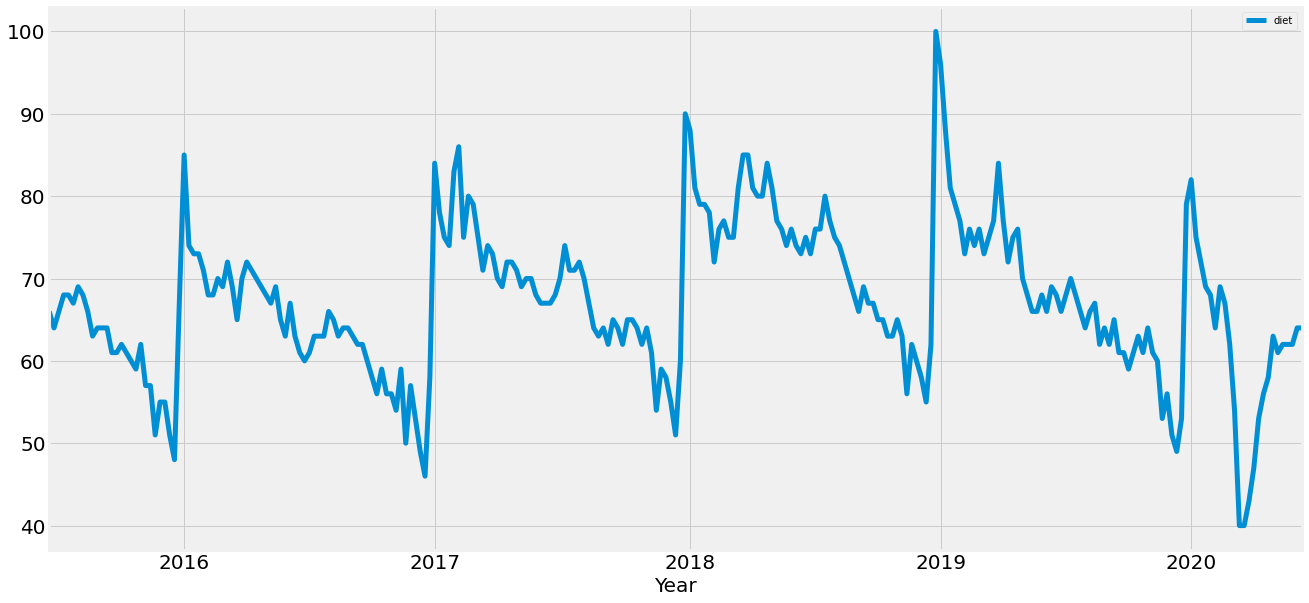

In [33]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

## Rolling Average

We will first try to plot the rolling average and check if there is any pattern

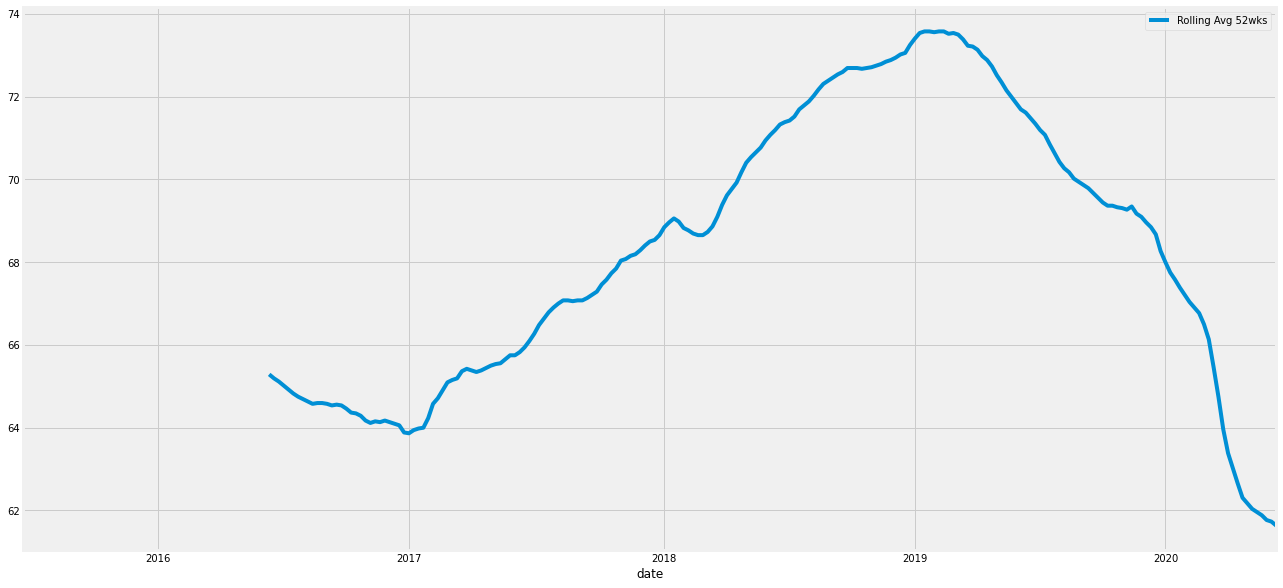

In [54]:
# .plot(figsize=(20,10), linewidth=5, fontsize=20);
#plt.xlabel('Year', fontsize=20)

# t = df.index
a = df.rolling(52).mean().plot()
# b = df.expanding().mean().plot()
#c = df.expanding().std().plot()
#plt.plot(t,a)
plt.legend(['Rolling Avg 52wks', 'Expanding Mean', 'Expand StDev'])
plt.show()

Since data is weekly basis, we will use a 52 weeks rolling average. The above graph shows the trends for keyword 'diet'. We see gradual increase from 2017 to 2019 and significant decline after 2019.

## Stationarity

### First-Order Differencing

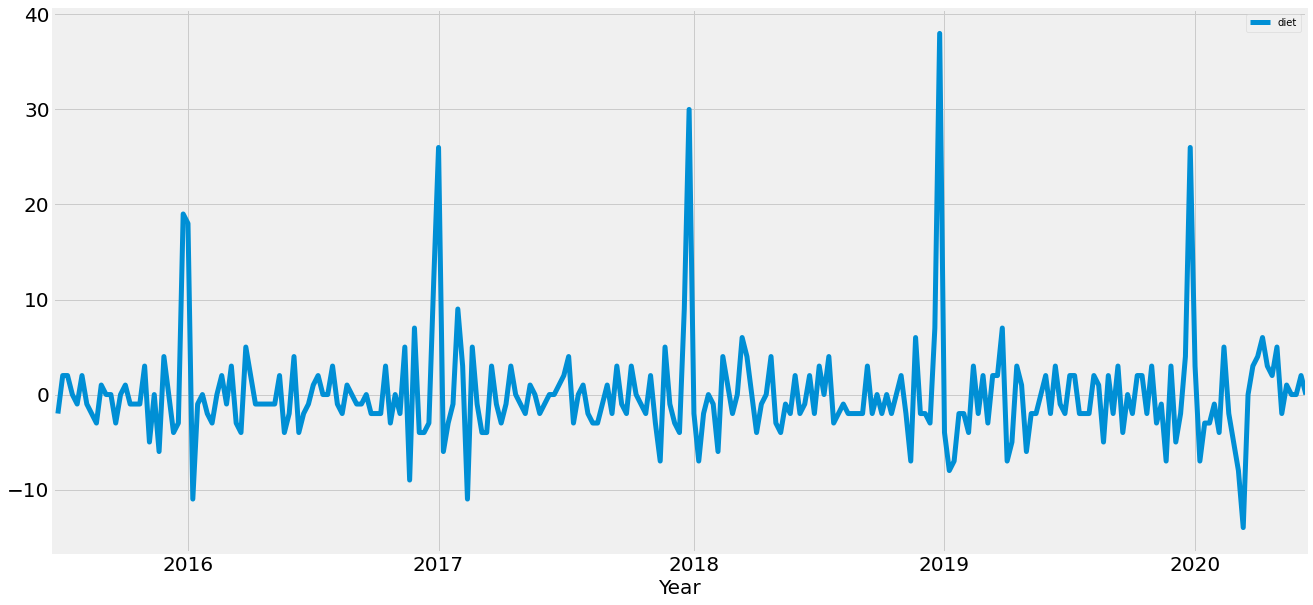

In [35]:
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

## Autocorrelation

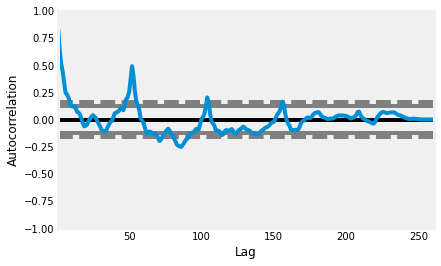

In [36]:
pd.plotting.autocorrelation_plot(df);

For keyword 'diet', We see there is autocorrelation in every 52 (weeks)

## Time Series Decomposition
We can visualize our time-series with a better package. 

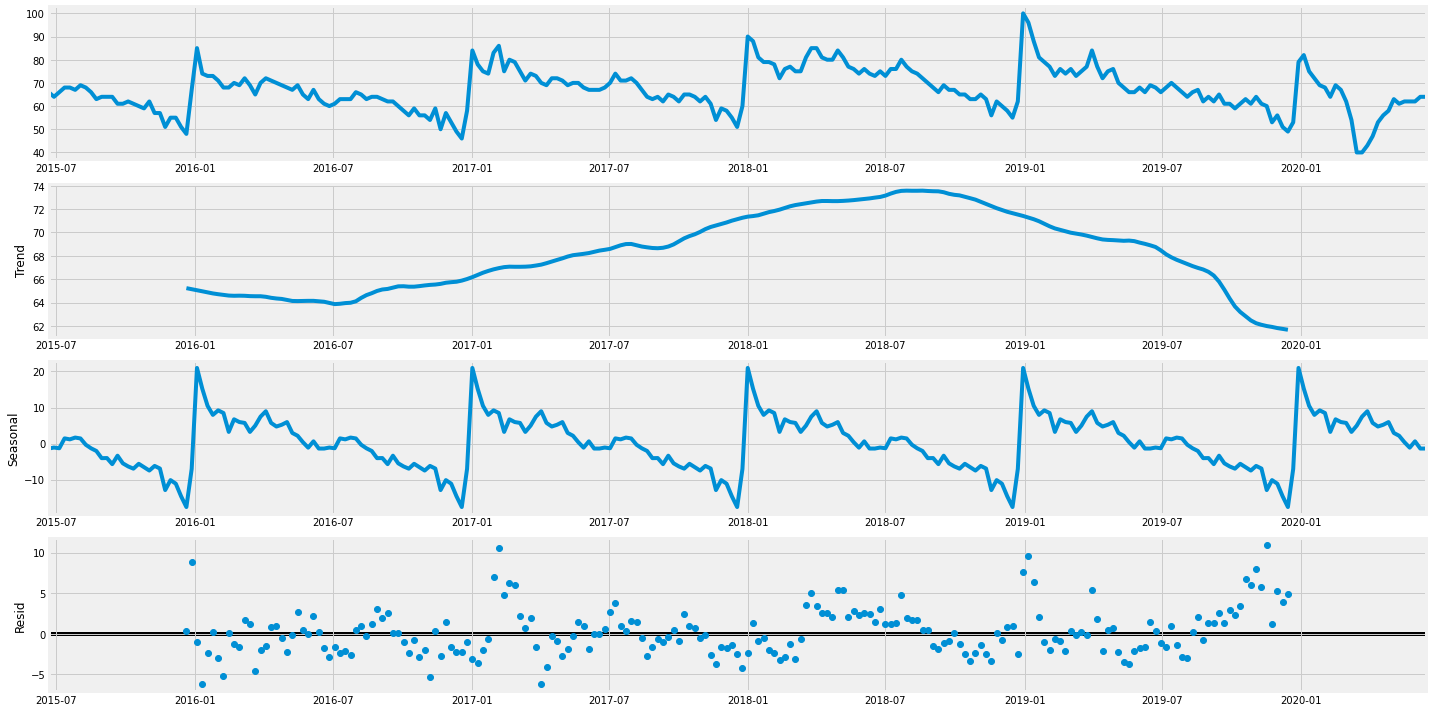

In [37]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show();

## Time Series Forecasting with ARIMA
We will try and find the optimal ARIMA parameters

In [38]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


We will try to use a 'grid search' to find an optimal set fo parameters that yield the best performance for ARIMA(p,d,q)

In [39]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

will try this ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:8.0


In [40]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8446      0.083     10.233      0.000       0.683       1.006
ma.L1         -0.9528      0.052    -18.337      0.000      -1.055      -0.851
ar.S.L52      -0.3007      0.072     -4.190      0.000      -0.441      -0.160
sigma2        13.0674      0.888     14.710      0.000      11.326      14.808


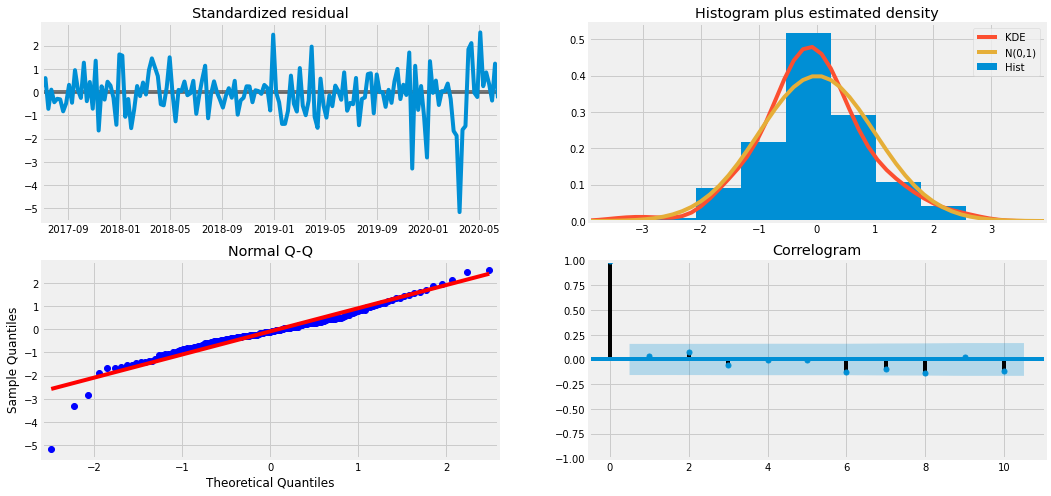

In [41]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# ARIMA (Machine Learning Mastery)
[Reference](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

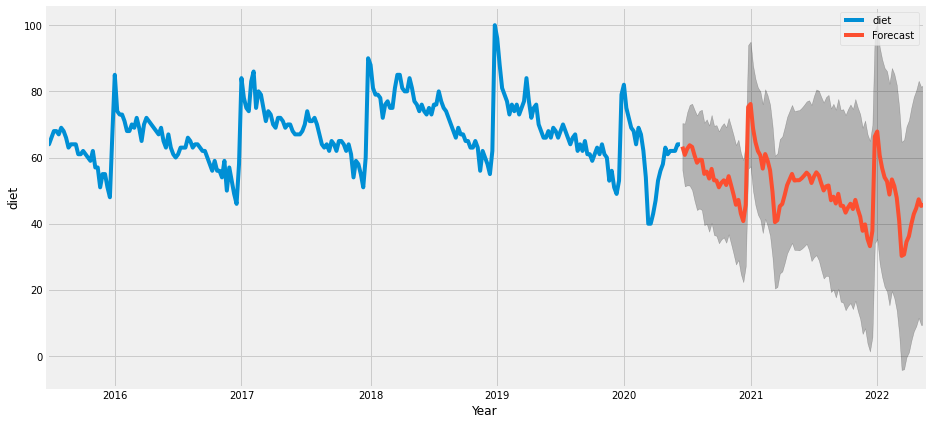

In [42]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel(my_keyword)
plt.legend()
plt.show()

ARIMA Model Results                              
Dep. Variable:                 D.diet   No. Observations:                  260
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -793.936
Method:                       css-mle   S.D. of innovations              5.126
Date:                Wed, 17 Jun 2020   AIC                           1601.872
Time:                        18:18:09   BIC                           1626.796
Sample:                    06-28-2015   HQIC                          1611.892
                         - 06-14-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0112      0.251     -0.045      0.964      -0.503       0.480
ar.L1.D.diet     0.0867      0.062      1.403      0.161      -0.034       0.208
ar.L2.D.diet    -0.2244      0.062     -3.630      0.000      -0.345     

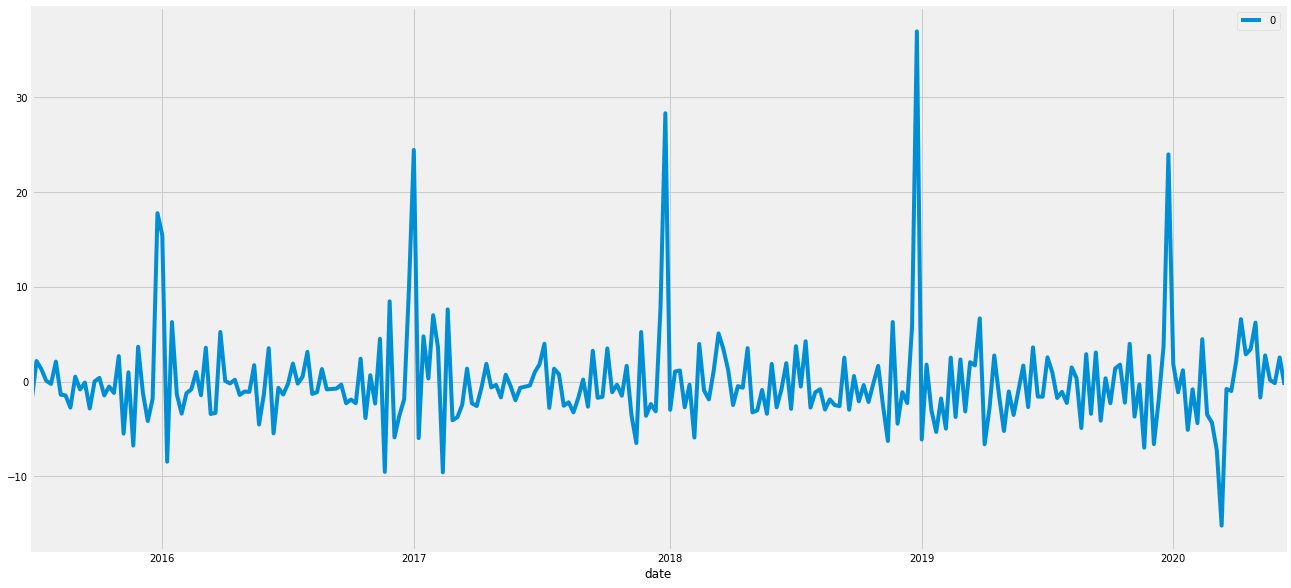

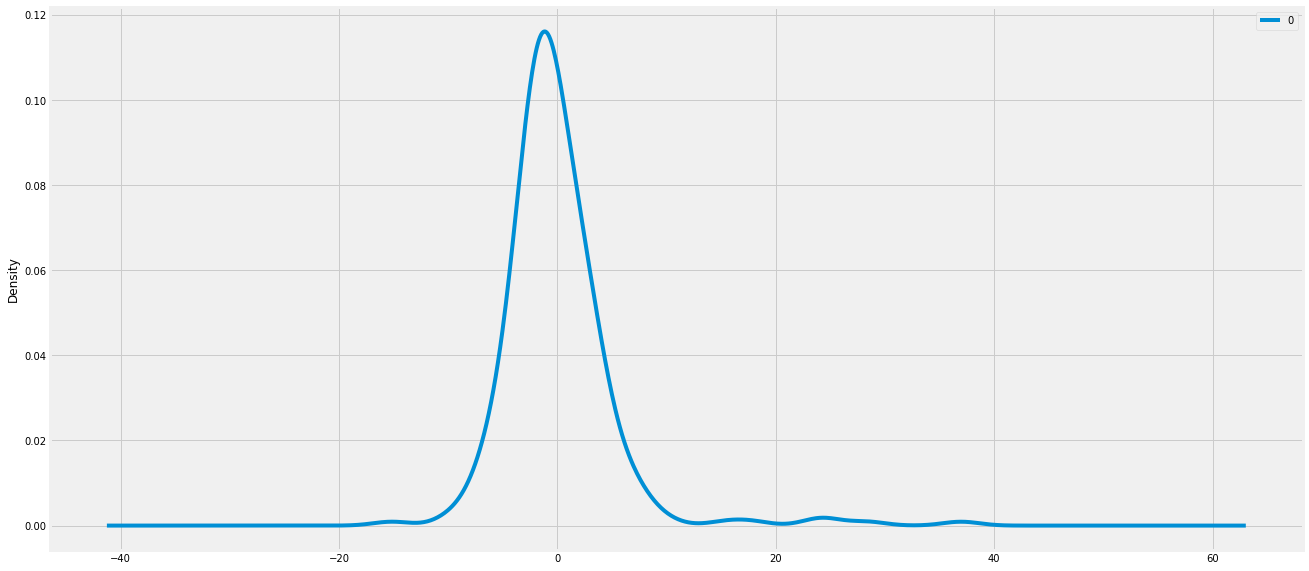

0
count  260.000000
mean     0.001246
std      5.135996
min    -15.187095
25%     -2.536047
50%     -0.800630
75%      1.757019
max     36.969667


In [43]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(df, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=67.096163, expected=65.000000
predicted=65.443952, expected=65.000000
predicted=65.241950, expected=63.000000
predicted=63.116443, expected=63.000000
predicted=63.283594, expected=65.000000
predicted=65.310981, expected=63.000000
predicted=62.159644, expected=56.000000
predicted=55.984192, expected=62.000000
predicted=64.451488, expected=60.000000
predicted=58.722534, expected=58.000000
predicted=57.177833, expected=55.000000
predicted=56.329223, expected=62.000000
predicted=62.716066, expected=100.000000
predicted=101.499657, expected=96.000000
predicted=83.955181, expected=88.000000
predicted=86.189374, expected=81.000000
predicted=87.026467, expected=79.000000
predicted=81.933397, expected=77.000000
predicted=78.056742, expected=73.000000
predicted=73.341786, expected=76.000000
predicted=77.562668, expected=74.000000
predicted=73.545766, expected=76.000000
predicted=76.179579, expected=73.000000
predicted=72.854287, expected=75.000000
predicted=75.511523, expected=77.00000

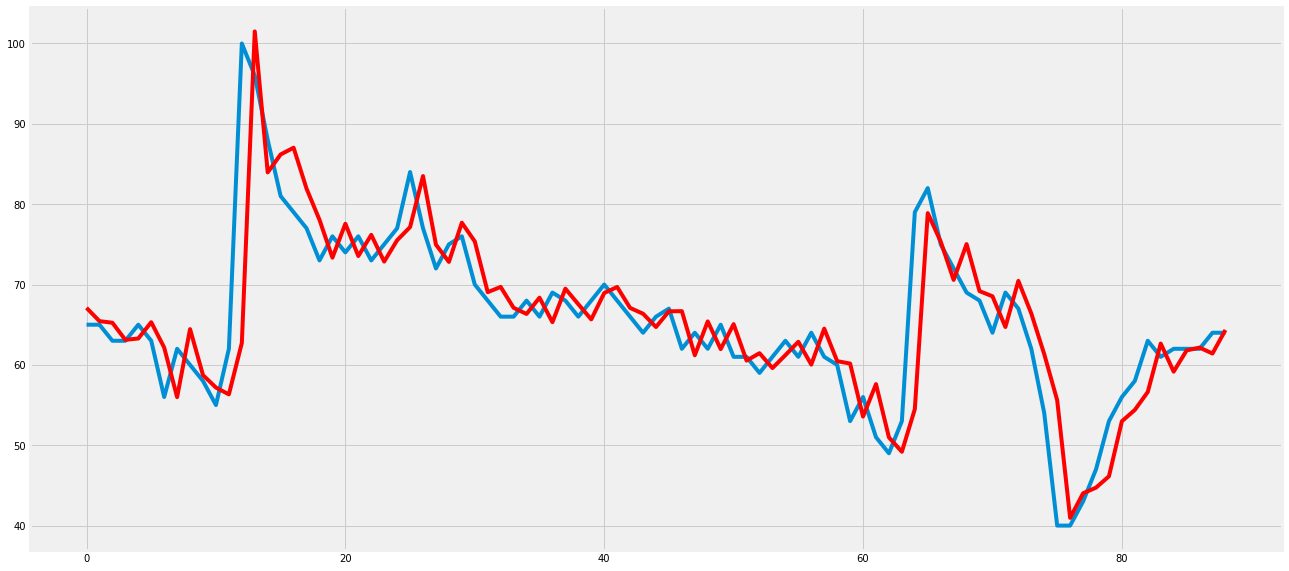

In [44]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()